<a href="https://colab.research.google.com/github/kwankoravich/covid19_chest_xray/blob/main/COVID_19_Pneumonia_detection_from_X_rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference

https://github.com/lindawangg/COVID-Net

https://github.com/med-air/Contrastive-COVIDNet

https://www.freecodecamp.org/news/deep-learning-with-pytorch/

https://github.com/sanchit2843/MLBasics/blob/master/IntelClassificationKaggle/Pytorch%20transfer%20learning%20tutorial%20%5B93%25acc%5D.ipynb

https://medium.com/swlh/image-classification-tutorials-in-pytorch-transfer-learning-19ebc329e200

https://towardsdatascience.com/pytorch-shap-explainable-convolutional-neural-networks-ece5f04c374f

https://github.com/marcotcr/lime

https://www.sciencedirect.com/science/article/pii/S2666827021000694

https://medium.com/intelligentmachines/implementation-of-class-activation-map-cam-with-pytorch-c32f7e414923

https://towardsdatascience.com/explainability-and-visibility-in-covid-19-x-ray-classifiers-with-deep-learning-c12c3247f905

https://www.kaggle.com/basu369victor/covid-19-detection-with-heat-map-visualization

https://github.com/jacobgil/pytorch-grad-cam

https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html

https://github.com/spacewalk01/Detecting-covid19-with-chest-XRay/blob/main/notebook.ipynb

#Import libraries

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6e372b80512da041eec4c3963fbfa66c202a10c8b7b77458b3e33efd06f90e78
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
!git clone https://github.com/med-air/Contrastive-COVIDNet

Cloning into 'Contrastive-COVIDNet'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 94 (delta 37), reused 84 (delta 31), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [ ]:
!pip install split-folders tqdm

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!gdown --id 1Wq_i3cMpUTHslUP1plzL76SeK66gLLXE 

Downloading...
From: https://drive.google.com/uc?id=1Wq_i3cMpUTHslUP1plzL76SeK66gLLXE
To: /content/kaggle.json
100% 68.0/68.0 [00:00<00:00, 112kB/s]


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download tawsifurrahman/covid19-radiography-database

 99% 736M/745M [00:04<00:00, 200MB/s]
100% 745M/745M [00:04<00:00, 178MB/s]


In [ ]:
!unzip /content/covid19-radiography-database.zip

In [ ]:
#!mv /content/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx newfile.txt

In [ ]:
!rm -rf /content/COVID-19_Radiography_Dataset/Lung_Opacity
!rm /content/COVID-19_Radiography_Dataset/COVID.metadata.xlsx
!rm /content/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx
!rm /content/COVID-19_Radiography_Dataset/Normal.metadata.xlsx
!rm /content/COVID-19_Radiography_Dataset/README.md.txt
!rm /content/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx

rm: cannot remove '/content/COVID-19_Radiography_Dataset/Viral': No such file or directory
rm: cannot remove 'Pneumonia.metadata.xlsx': No such file or directory


In [ ]:
import sys
# Set PATHs
PATH_TO_SENTEVAL = '/content/Contrastive-COVIDNet/code'

# import SentEval
sys.path.insert(0, PATH_TO_SENTEVAL)
from model import *

In [ ]:
#importing required modules
import gdown
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T
from efficientnet_pytorch import EfficientNet
import os
import torch.optim as optim
from PIL import ImageFile
from sklearn.metrics import accuracy_score
import imageio
from tqdm import tqdm
import splitfolders

Check CUDA

In [ ]:
#Checking the availability of a GPU
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda


# Import Data

In [ ]:
#importing data
#Dataset address
url = 'https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY'
output = 'data.zip'
gdown.download(url, output, quiet=False)
#giving zip file name
data_dir='./data.zip'
#Extracting data from zip file
with zipfile.ZipFile(data_dir, 'r') as zf:
  zf.extractall('./data/')

Downloading...
From: https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY
To: /content/data.zip
100%|██████████| 46.1M/46.1M [00:00<00:00, 233MB/s]


In [ ]:
splitfolders.ratio("/content/COVID-19_Radiography_Dataset", output="COVID_data", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 15153 files [00:03, 4259.82 files/s]


In [ ]:
import os

_, _, files_covid = next(os.walk("/content/COVID_data/test/COVID"))
print(len(files_covid))
_, _, files_normal = next(os.walk("/content/COVID_data/test/Normal"))
print(len(files_normal))
_, _, files_pneumonia = next(os.walk("/content/COVID_data/test/Viral Pneumonia"))
print(len(files_pneumonia))


363
1020
135


#Preprocess

In [ ]:
# from PIL import Image
# transform = T.Compose([
#     T.ToTensor()
# ])

# img_path = '/content/COVID_data/train/COVID/COVID-10.png'
# img = Image.open(img_path)

# # get tensor image
# img_tr = transform(img)
  
# # calculate mean and std
# mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
  
# # print mean and std
# print("mean and std before normalize:")
# print("Mean of the image:", mean)
# print("Std of the image:", std)

In [ ]:
#declaring batch size
batch_size = 64

#applying required transformations on the dataset
img_transforms = {
    'train':
    T.Compose([
        T.Resize(size=(224,224)), 
        T.ToTensor()
        #T.Normalize(mean = (-0.8694,), std = (0.5091,)), 
        ]),

    'val':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor()
        #T.Normalize(mean = (-0.8763,), std = (0.5081,))
        ]),

    'test':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor()
        #T.Normalize(mean = (-0.8893,), std = (0.5102,))
        ]),
     }

# creating Location of data: train, validation, test
data = '/content/COVID_data/'

train_path=os.path.join(data,'train')
valid_path=os.path.join(data,'val')
test_path=os.path.join(data,'test')


# creating Datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=img_transforms['train'])
valid_file=datasets.ImageFolder(valid_path,transform=img_transforms['val'])
test_file=datasets.ImageFolder(test_path,transform=img_transforms['test'])


#Creating loaders for the dataset
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'val':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

In [ ]:
train_file[-1]

(tensor([[[0.1961, 0.1686, 0.1569,  ..., 0.0667, 0.0627, 0.0667],
          [0.1922, 0.1647, 0.1647,  ..., 0.0667, 0.0627, 0.0667],
          [0.1961, 0.1686, 0.1686,  ..., 0.0667, 0.0627, 0.0706],
          ...,
          [0.1882, 0.2471, 0.2941,  ..., 0.1608, 0.2039, 0.2784],
          [0.1922, 0.2510, 0.2980,  ..., 0.1608, 0.2039, 0.2784],
          [0.2000, 0.2510, 0.2941,  ..., 0.1608, 0.2078, 0.2863]],
 
         [[0.1961, 0.1686, 0.1569,  ..., 0.0667, 0.0627, 0.0667],
          [0.1922, 0.1647, 0.1647,  ..., 0.0667, 0.0627, 0.0667],
          [0.1961, 0.1686, 0.1686,  ..., 0.0667, 0.0627, 0.0706],
          ...,
          [0.1882, 0.2471, 0.2941,  ..., 0.1608, 0.2039, 0.2784],
          [0.1922, 0.2510, 0.2980,  ..., 0.1608, 0.2039, 0.2784],
          [0.2000, 0.2510, 0.2941,  ..., 0.1608, 0.2078, 0.2863]],
 
         [[0.1961, 0.1686, 0.1569,  ..., 0.0667, 0.0627, 0.0667],
          [0.1922, 0.1647, 0.1647,  ..., 0.0667, 0.0627, 0.0667],
          [0.1961, 0.1686, 0.1686,  ...,

In [ ]:
train_file[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
# loader = torch.utils.data.DataLoader(train_file, batch_size=len(train_file), num_workers=1)
# y = next(iter(loader))
# y[0].mean(), y[0].std()

In [ ]:
# loader = torch.utils.data.DataLoader(valid_file, batch_size=len(valid_file), num_workers=1)
# z = next(iter(loader))
# z[0].mean(), z[0].std()

In [ ]:
# loader = torch.utils.data.DataLoader(test_file, batch_size=len(test_file), num_workers=1)
# k = next(iter(loader))
# k[0].mean(), k[0].std()

In [ ]:
# #inverse normalization for image plot

# inv_normalize =  T.Normalize(
#     mean=-1*np.divide(k[0].mean(),k[0].std()),
#     std=1/k[0].std()
# )

In [ ]:
classes = train_file.classes
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

In [ ]:
encoder

{0: 'COVID', 1: 'Normal', 2: 'Viral Pneumonia'}

In [ ]:
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

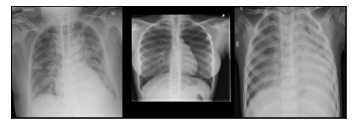

In [ ]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

covid = read_image('/content/COVID_data/train/COVID/COVID-10.png')
normal = read_image('/content/COVID_data/train/Normal/Normal-1.png')
pneumonia = read_image('/content/COVID_data/train/Viral Pneumonia/Viral Pneumonia-10.png')

grid = make_grid([covid,normal, pneumonia])
show(grid)

#Model

In [ ]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained = True)
resnet101 = models.resnet101(pretrained = True)
resnet18 = models.resnet18(pretrained = True)
vgg16 = models.vgg16(pretrained = True)

In [ ]:
covid_net = CovidNet()

In [ ]:
#importing the pretrained EfficientNet model

model_transfer = EfficientNet.from_pretrained('efficientnet-b0')

# Freeze weights
for param in model_transfer.parameters():
    param.requires_grad = False
in_features = model_transfer._fc.in_features

for param in resnet50.parameters():
    param.requires_grad = False
in_features_resnet50 = resnet50.fc.in_features

for param in resnet101.parameters():
    param.requires_grad = False
in_features_resnet101 = resnet101.fc.in_features

for param in resnet18.parameters():
    param.requires_grad = False
in_features_resnet18 = resnet18.fc.in_features

for param in vgg16.parameters():
    param.requires_grad = False



# Defining Dense top layers after the convolutional layers
model_transfer._fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, 3),
    )

# resnet50._fc = nn.Sequential(
#     nn.BatchNorm1d(num_features=in_features),    
#     nn.Linear(in_features, 512),
#     nn.ReLU(),
#     nn.BatchNorm1d(512),
#     nn.Linear(512, 128),
#     nn.ReLU(),
#     nn.BatchNorm1d(num_features=128),
#     nn.Dropout(0.4),
#     nn.Linear(128, 3),
#     )

resnet50.fc = nn.Linear(in_features=in_features_resnet50, out_features=3, bias=True)
resnet18.fc = nn.Linear(in_features=in_features_resnet18, out_features=3, bias=True)

resnet101._fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, 3),
    )

vgg16.classifier = nn.Sequential(
  nn.Linear(in_features=25088, out_features=4096, bias=True),
  nn.ReLU(inplace=True),
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(in_features=4096, out_features=4096, bias=True),
  nn.ReLU(inplace=True),
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(in_features=4096, out_features=3, bias=True)
)

if use_cuda:
    model_transfer = model_transfer.cuda()
    resnet50 = resnet50.cuda()
    resnet101 = resnet101.cuda()
    resnet18 = resnet18.cuda()
    vgg16 = vgg16.cuda()
    covid_net = covid_net.cuda()

Loaded pretrained weights for efficientnet-b0


#Training

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, device, save_path):

  valid_loss_min = np.Inf
  training_loss = []
  validation_loss = []

  for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    
    #train model
    model.train()
    for batch, (data, target) in tqdm(enumerate(loaders['train'])):
      #if use_cuda: # GPU
      data, target = data.to(device), target.to(device)
      
      
      optimizer.zero_grad
      #output, x = model(data)
      output = model(data)
      #print(output)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      train_loss = train_loss + ((1/(batch+1))*(loss.data - train_loss))
      #train_loss += loss.item()
      

    #development model
    model.eval()
    for batch, (data, target) in tqdm(enumerate(loaders['val'])):
      #if use_cuda: # GPU
      data, target = data.to(device), target.to(device)
      
      
      optimizer.zero_grad
      #output, x = model(data)
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      valid_loss = valid_loss + ((1/(batch+1))*(loss.data - valid_loss))

    train_loss = train_loss/len(train_file)
    valid_loss = valid_loss/len(valid_file)

    training_loss.append(train_loss)
    validation_loss.append(valid_loss)

    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
              epoch, 
              train_loss,
              valid_loss
              ))
        
    ## saving the model if validation loss has decreased
  if valid_loss < valid_loss_min:
    torch.save(model.state_dict(), save_path)
    valid_loss_min = valid_loss


  return model, training_loss, validation_loss

In [ ]:
NUM_EPOCHS = 2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transfer.parameters(), lr = 0.001)
optimizer_resnet50 = torch.optim.Adam(resnet50.parameters(), lr = 0.001)
optimizer_resnet101 = torch.optim.Adam(resnet101.parameters(), lr = 0.001)
optimizer_resnet18 = torch.optim.Adam(resnet18.parameters(), lr = 0.001)
optimizer_vgg16 = torch.optim.Adam(vgg16.parameters(), lr = 0.001)
optimizer_covid_net = torch.optim.Adam(covid_net.parameters(), lr = 0.001)
model, train_loss, validation_loss = train(NUM_EPOCHS, loaders_transfer, resnet18, optimizer_resnet18, criterion, device, 'efficientnet-b0.pt')

190it [00:48,  3.96it/s]
24it [00:05,  4.03it/s]


Epoch: 1 	Training Loss: 0.000521 	Validation Loss: 0.011484


190it [00:47,  3.96it/s]
24it [00:05,  4.02it/s]


Epoch: 2 	Training Loss: 0.001178 	Validation Loss: 0.002438


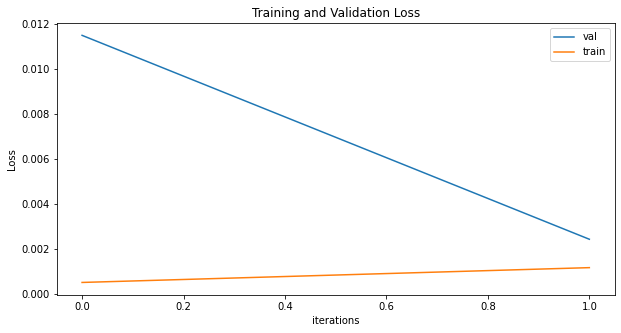

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(validation_loss,label="val")
plt.plot(train_loss,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import random

def incorrect_class(num_image, label, image, pred, encoder, inv_normalize = None):
  print('Classes in order Actual and Predicted')
  num_row = num_image // 3
  fig, axes = plt.subplots(figsize = (20,15), nrows = num_row, ncols = 3)

  for ax in axes.flatten():
    a = random.randint(0, len(label) - 1) 
    ima, correct, wrong = image[a], label[a], pred[a]
    ima = torch.from_numpy(ima)
    correct = int(correct)
    c = encoder[correct]
    wrong = int(wrong)
    w = encoder[wrong]
    f = 'Actual: '+ c + ', ' +'Predicted: '+ w
    if inv_normalize !=None:
            ima = inv_normalize(ima)
    ima = ima.numpy().transpose(1,2,0)
    image_incorrect = ax.imshow(ima)
    ax.set_title(f)
    ax.axis('off')
  plt.show()

# Testing

In [ ]:
# def test(loaders, model, criterion, use_cuda):

#     # monitoring test loss and accuracy
#     test_loss = 0.
#     correct = 0.
#     total = 0.
#     preds = []
#     targets = []

#     model.eval()
#     for batch_idx, (data, target) in enumerate(loaders['test']):
#         # moving to GPU
#         if use_cuda:
#             data, target = data.cuda(), target.cuda()
#         # forward pass
#         output = model(data)
#         # calculate the loss
#         loss = criterion(output, target)
#         # updating average test loss 
#         test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
#         # converting the output probabilities to predicted class
#         pred = output.data.max(1, keepdim=True)[1]
#         preds.append(pred)
#         targets.append(target)
#         # compare predictions
#         correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
#         total += data.size(0)
    
#     return preds, targets

In [ ]:
def test(loaders, model, criterion, device):
  test_loss = 0.0
  correct = 0.0
  total = 0.0
  pred = []
  targets = []
  true = []
  pred_wrong = []
  true_wrong = []
  image = []

  model.eval()
  for batch, (data, target) in tqdm(enumerate(loaders['test'])):
      #if use_cuda: # GPU
      data, target = data.to(device), target.to(device)
      
      
      #output, x = model(data)
      output = model(data)
      loss = criterion(output, target)
      loss.backward()

      test_loss = test_loss + (1/(batch+1))*(loss.data - test_loss)

      # converting the output probabilities to predicted class
      preds = output.data.max(1, keepdim=True)[1]
      
      # compare predictions
      #correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
      correct += torch.sum(preds == target.data)
      total += data.size(0)

      #change torch to numpy
      preds = preds.cpu().numpy()
      target = target.cpu().numpy()
      preds = np.reshape(preds,(len(preds),1))
      target = np.reshape(target,(len(preds),1))
      data = data.cpu().numpy()
      #pred.append(preds)
      #targets.append(target)
      
  
      for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
  # return preds, targets
  return preds,target, true, image, true_wrong, pred_wrong

In [ ]:
# preds, targets = test(loaders_transfer, model, criterion, device)
preds, targets, true, image_all, true_wrong, pred_wrong = test(loaders_transfer, model, criterion, device)

24it [00:06,  3.58it/s]


#Prediction

In [ ]:
#converting the tensor object to a list for metric functions

# preds2, targets2, image2, true_wrong2, pred_wrong2 = [],[],[],[],[]
# preds2, targets2 = [],[]
# for i in preds:
#   for j in range(len(i)):
#     preds2.append(i.cpu().numpy()[j])
# for i in targets:
#   for j in range(len(i)):
#     targets2.append(i.cpu().numpy()[j])
# for i in image:
#   for j in range(len(i)):
#     image2.append(i.cpu().numpy()[j])
# for i in true_wrong:
#   for j in range(len(i)):
#     true_wrong2.append(i.cpu().numpy()[j])
# for i in pred_wrong:
#   for j in range(len(i)):
#     pred_wrong2.append(i.cpu().numpy()[j])

Classes in order Actual and Predicted


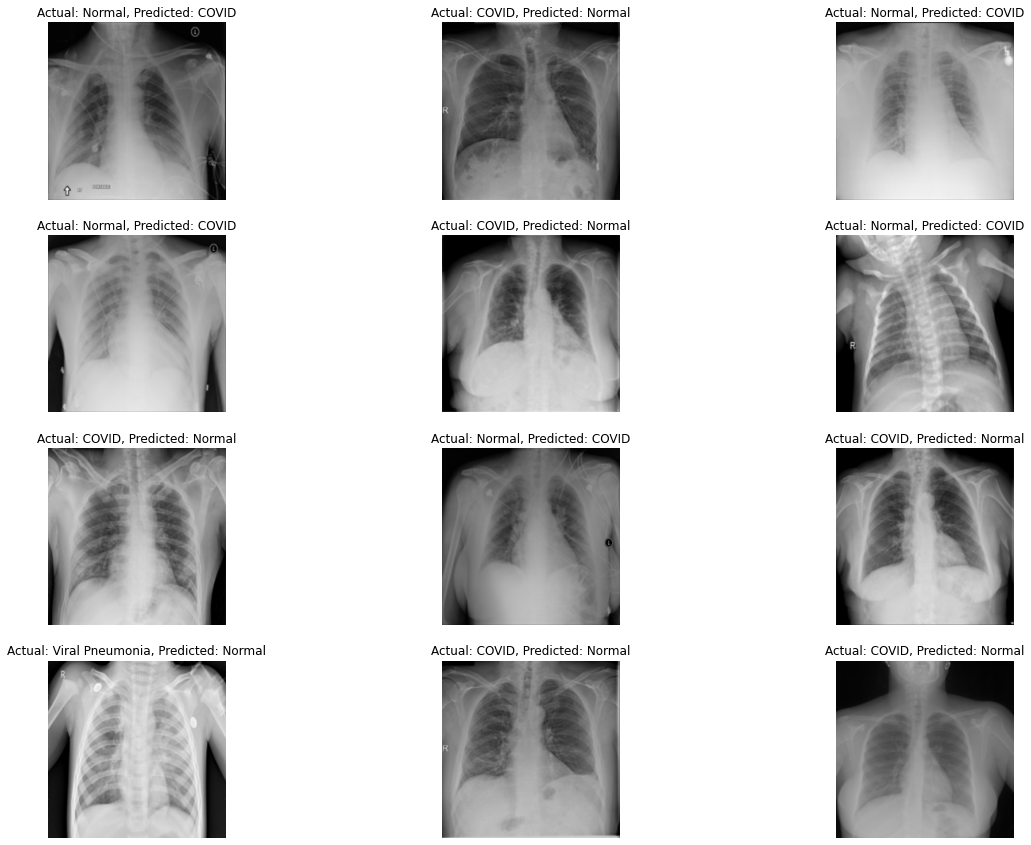

In [ ]:
incorrect_class(12, true_wrong, image_all, pred_wrong, encoder)

#Accuracy

In [ ]:
#Computing the accuracy
acc = accuracy_score(targets, preds)
print("Accuracy: ", acc)

Accuracy:  0.8913043478260869


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.91      0.94      0.92        32
           2       0.50      1.00      0.67         1

    accuracy                           0.89        46
   macro avg       0.77      0.90      0.81        46
weighted avg       0.90      0.89      0.89        46



In [ ]:
!git clone https://github.com/DTrimarchi10/confusion_matrix

fatal: destination path 'confusion_matrix' already exists and is not an empty directory.


In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(targets, preds)

In [ ]:
from confusion_matrix.cf_matrix import make_confusion_matrix

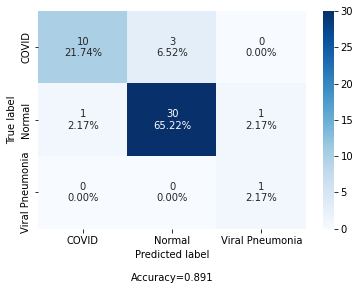

In [ ]:
#labels = ['True Neg','False Pos','False Neg','True Pos']
#categories = ['COVID', 'Normal', 'Viral Pneumonia']
make_confusion_matrix(cf_matrix,  
                      categories = classes,
                      cmap='Blues')

In [ ]:
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(classes)), classes, rotation=50)
  thisplot = plt.bar(range(len(classes)), predictions_array, color = '#777777')
  plt.ylim([0,1])
  predicted_labels = np.argmax(predictions_array)

  thisplot[predicted_labels].set_color('red')
  thisplot[true_label].set_color('blue')



def show_images_with_preds(images, labels, soft_preds):
  plt.figure(figsize=(14,6))
  _, preds = torch.max(soft_preds, 1)

  for i, image in enumerate(images):
    if i > 4:
      break
    
    plt.subplot(2, 5, i+1, xticks=[], yticks=[])
    image = image.cpu().detach().numpy().transpose((1,2,0))
    #image = image * std + mean
    image = np.clip(image, 0., 1.)
    plt.imshow(image)

    if preds[i] == labels[i]:
      col = 'blue'
    else:
      col = 'red'


    plt.xlabel("{} {:2.0f}% (truth: {})".format(classes[int(preds[i].numpy())],
                                100*np.max(soft_preds[i].numpy()),
                                classes[labels[i]]),
                                color=col)

    plt.subplot(2, 5, 6+i, xticks=[], yticks=[])
    plot_value_array(i, soft_preds[i], labels)

  plt.tight_layout()
  plt.show()


def visualize_preds(model, loader, device):
  model.eval()
  images, labels = next(iter(loader))
  images = images.to(device)
  outputs = model(images)
  outputs = outputs.cpu().detach()
  soft_preds = torch.softmax(outputs, dim=1)

  show_images_with_preds(images, labels, soft_preds)

Predictions after training


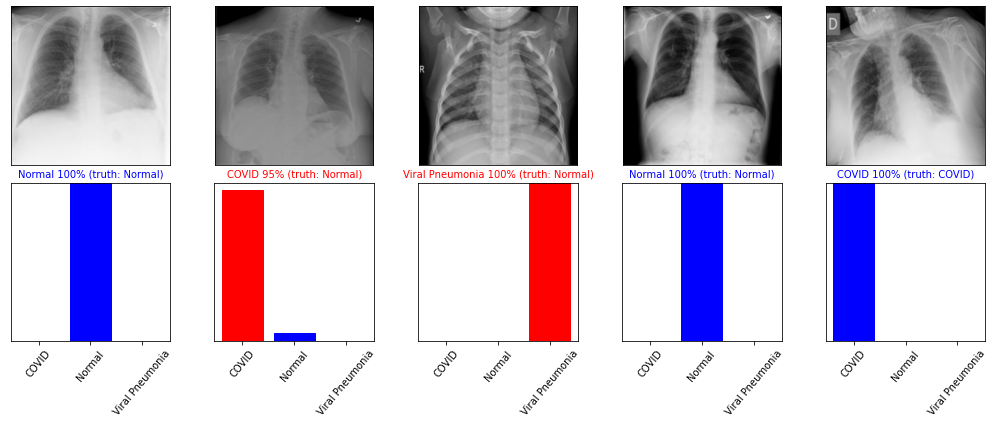

In [ ]:
print('Predictions after training')
visualize_preds(model, loaders_transfer['test'], device)

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# cf_matrix = confusion_matrix(targets2, preds2)

# group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
# labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#           zip(group_names,group_counts,group_percentages)]
# labels = np.asarray(labels).reshape(2,2)
# sns.heatmap(cf_matrix, annot=labels, fmt='')

# Explaning Model

In [ ]:
#!pip install shap

     |████████████████████████████████| 564 kB 8.0 MB/s 


In [ ]:
# import shap
# loader = torch.utils.data.DataLoader(test_file, batch_size=16, num_workers=1)
# batch_1 = next(iter(loader))
# batch_2 = next(iter(loader))
# batch = torch.cat((batch_1[0], batch_2[0]))
# images = batch

# background = images[:10].to('cpu')
# test_images = images[10:15].to('cpu')

# model2 = model.to('cpu')

# e = shap.DeepExplainer(model2, background)
# shap_values = e.shap_values(test_images)

In [ ]:
# shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
# test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

In [ ]:
# shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
!pip install grad-cam==1.3.5 # I use this version because I need to configure target_category

     |████████████████████████████████| 1.8 MB 10.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.5-py3-none-any.whl size=22419 sha256=3799f2e2b6c6074e18a2180646c3bddcca68eedf267c8b7f6f6a0c0f2c248b15
  Stored in directory: /root/.cache/pip/wheels/89/d1/a6/41cb46183c56fe9e78ba80781ca35c3bc2728406b694fb7a13
Successfully built grad-cam


In [ ]:
# loader = torch.utils.data.DataLoader(test_file, batch_size=len(test_file), num_workers=1)
# k = next(iter(loader))
# k[0].mean(), k[0].std()

In [ ]:
#!pip install torch_summary

In [ ]:
#from torchsummary import summary

In [ ]:
#summary(model, torch.zeros(64, 3,7,7))

In [ ]:
g = test_file[3][0].permute(1, 2, 0).numpy()
#g = g/255
#g = g.transpose(2,1,0)
#g = g.swapaxes(0,2)
g.shape

(224, 224, 3)

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
#from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model_1 = resnet50(pretrained=True)
#model_2 = model.cpu()
target_layers = [model_1.layer4[-1]]
#target_layers = [model.layer4[-1]]
#target_layers = [model_2.layer4[-1]]
loader = torch.utils.data.DataLoader(test_file, batch_size=64, num_workers=1)
k = next(iter(loader))
#k[0].mean(), k[0].std()
input_tensor = k[0] # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!
target_category = k[1]
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model_1, target_layers=target_layers, use_cuda=True)
# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
#targets = [ClassifierOutputTarget(k[1][0]), ClassifierOutputTarget(100)]
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor = input_tensor, target_category = target_category, aug_smooth=False, eigen_smooth=False)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(g, grayscale_cam, use_rgb=True)

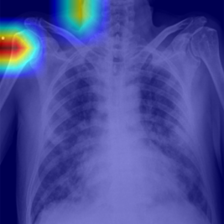

In [ ]:
from PIL import Image
Image.fromarray(visualization)

torch.Size([64, 3, 224, 224])


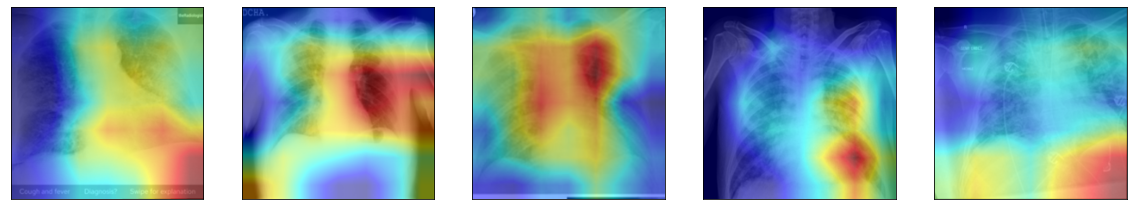

In [ ]:
import cv2

model_2 = model
pic, labels = next(iter(loaders_transfer['test']))
target_layers = [model_1.layer4[-1]]
input_tensor = pic
target_category = labels
print(pic.shape)
cam = GradCAM(model = model_1, target_layers = target_layers, use_cuda = True)

grayscale_cam = cam(input_tensor = input_tensor, target_category = target_category)

plt.figure(figsize=(20,6))

for i in range(5):
    
    #image_path = test_dataset.images[i]
    # image_path = test_file[i][0].permute(1, 2, 0).numpy()
    # rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    # rgb_img = cv2.resize(rgb_img, (224, 224))
    # rgb_img = np.float32(rgb_img) / 255
    rgb_img = test_file[i][0].permute(1, 2, 0).numpy()

    plt.subplot(1, 5, i+1, xticks=[], yticks=[])        
    cam_1 = grayscale_cam[i, :]
    visualization = show_cam_on_image(rgb_img, cam_1, use_rgb=True)

    plt.imshow(visualization)

In [ ]:
target_category.shape

torch.Size([64])

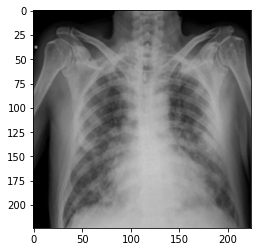

In [ ]:
plt.imshow(test_file[3][0].permute(1, 2, 0) )

In [ ]:
import requests
import torchvision
image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
image_float_np = np.float32(image) / 255

In [ ]:
image_float_np.shape

(224, 224, 3)

In [ ]:
vgg16 = models.vgg16(pretrained=True) 
mod = nn.Sequential(*list(vgg16.children())[:-1])

In [ ]:
mod

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from torch.autograd import Variable
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() 
        #img = images
        self.fc=nn.Linear(512,3)

    
    def forward(self,x):     
        x=x.view(512,7*7).mean(1).view(1,-1)
        x=self.fc(x)
        return  F.softmax(x,dim=1)

In [ ]:
params = list(Net().parameters())
weight = np.squeeze(params[-1].data.numpy())

In [ ]:
model=nn.Sequential(mod,Net())

In [ ]:
import cv2

In [ ]:
def return_CAM(feature_conv, weight, class_idx):
    # generate the class -activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [ ]:
normalize = T.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = T.Compose([
   T.Resize((224,224)),
   T.ToTensor(),
   normalize
])

In [ ]:
test_file[0]

(tensor([[[0.2392, 0.2471, 0.2471,  ..., 0.0902, 0.0863, 0.0784],
          [0.2118, 0.2078, 0.2157,  ..., 0.0980, 0.0941, 0.0863],
          [0.2000, 0.1961, 0.2078,  ..., 0.1020, 0.0980, 0.0902],
          ...,
          [0.4392, 0.4314, 0.4353,  ..., 0.4941, 0.4902, 0.4902],
          [0.4353, 0.4353, 0.4392,  ..., 0.4902, 0.4863, 0.4745],
          [0.4353, 0.4431, 0.4392,  ..., 0.2784, 0.2667, 0.2314]],
 
         [[0.2392, 0.2471, 0.2471,  ..., 0.0902, 0.0863, 0.0784],
          [0.2118, 0.2078, 0.2157,  ..., 0.0980, 0.0941, 0.0863],
          [0.2000, 0.1961, 0.2078,  ..., 0.1020, 0.0980, 0.0902],
          ...,
          [0.4392, 0.4314, 0.4353,  ..., 0.4941, 0.4902, 0.4902],
          [0.4353, 0.4353, 0.4392,  ..., 0.4902, 0.4863, 0.4745],
          [0.4353, 0.4431, 0.4392,  ..., 0.2784, 0.2667, 0.2314]],
 
         [[0.2392, 0.2471, 0.2471,  ..., 0.0902, 0.0863, 0.0784],
          [0.2118, 0.2078, 0.2157,  ..., 0.0980, 0.0941, 0.0863],
          [0.2000, 0.1961, 0.2078,  ...,

In [ ]:
predicted_labels = []
for img_tensor in test_file:
    
    # fname = fname.rstrip('\n')    
    # img_pil = Image.open(org_loc+fname+'.png')
    #img_tensor = preprocess(img_pil)
    img_variable = Variable(img_tensor[0].unsqueeze(0))
    logit = model(img_variable)

    h_x = F.softmax(logit, dim=1).data.squeeze()
 
    probs, idx = h_x.sort(0, True)
    probs = probs.detach().numpy()
    idx = idx.numpy()
    
    predicted_labels.append(idx[0])
    predicted =  loaders_transfer['test'].dataset.classes[idx[0]]
    
    print("Target: " + 'A' + " | Predicted: " +  predicted) 
 
    features_blobs = mod(img_variable)
    features_blobs1 = features_blobs.cpu().detach().numpy()
    CAMs = return_CAM(features_blobs1, weight, [idx[0]])

    readImg = org_loc+fname+'.png'
    img = cv2.imread(readImg)
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.5 + img * 0.5
  
    cv2.imwrite("image_1", result)

Target: A | Predicted: COVID


ValueError: ignored